In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Parameter space exploration

In [3]:
ava_df = pd.read_csv("../results/lrge_ava_estimates.csv")
ava_df

,sample,strategy,n_reads,repeat,estimate,memory,cpu_time
0,ATCC_35897,long,50000,0,2822438.0,2782088,914.89
1,ATCC_19119,long,50000,0,2976251.0,1531048,312.56
2,BPH2947,long,50000,0,2985959.0,5464932,1896.34
3,ATCC_10708,long,50000,0,4766843.0,758728,59.15
4,KPC2,long,50000,0,5939814.0,6311512,1525.81
...,...,...,...,...,...,...,...
331,ATCC_BAA-679,rand,5000,2,3017667.0,300256,13.83
332,ATCC_BAA-679,rand,5000,0,2952920.0,314212,14.50
333,ATCC_25922,rand,5000,0,5228012.0,285324,17.24
334,ATCC_25922,rand,5000,2,5218293.0,268132,16.16


In [4]:
twoset_df = pd.read_csv("../results/lrge_2set_estimates.csv")
twoset_df

,sample,strategy,longest,overlap,repeat,estimate,memory,cpu_time
0,ATCC_35897,long,5000,1000,0,2.700825e+06,1027036,50.65
1,ATCC_19119,long,5000,1000,0,2.898175e+06,1107080,46.82
2,BPH2947,long,5000,1000,0,2.526618e+06,1604472,93.09
3,ATCC_10708,long,5000,1000,0,4.392490e+06,908236,28.05
4,KPC2,long,5000,1000,0,4.662014e+06,2095688,90.21
...,...,...,...,...,...,...,...,...
2011,ATCC_BAA-679,rand,100,10000,2,3.029200e+06,71424,4.78
2012,ATCC_BAA-679,rand,100,10000,0,3.016585e+06,63424,4.39
2013,ATCC_25922,rand,100,10000,0,5.067147e+06,61056,6.32
2014,ATCC_25922,rand,100,10000,1,5.390512e+06,62784,6.26


In [5]:
samples = set(ava_df["sample"])

In [6]:
true_sizes = {}
for sample in samples:
    size = int(Path(f"../data/true_sizes/{sample}.gsize").read_text())
    true_sizes[sample] = size

In [7]:
ava_df["true_size"] = ava_df["sample"].map(true_sizes)
ava_df["rel_size"] = ava_df["estimate"] / ava_df["true_size"]
ava_df["rel_err"] = (ava_df["estimate"] - ava_df["true_size"]) / ava_df["true_size"] * 100
ava_df["method"] = "ava"
twoset_df["true_size"] = twoset_df["sample"].map(true_sizes)
twoset_df["rel_size"] = twoset_df["estimate"] / twoset_df["true_size"]
twoset_df["rel_err"] = (twoset_df["estimate"] - twoset_df["true_size"]) / twoset_df["true_size"] * 100
twoset_df["method"] = "2set"

In [8]:
def add_identity(axes, *line_args, **line_kwargs):
    (identity,) = axes.plot([], [], *line_args, **line_kwargs)

    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])

    callback(axes)
    axes.callbacks.connect("xlim_changed", callback)
    axes.callbacks.connect("ylim_changed", callback)
    return axes

In [10]:
data = twoset_df.query("estimate < 1e9")
sns.lmplot(
    data=data,
    x="true_size",
    y="estimate",
    hue="strategy",
    col="longest",
    row="overlap",
)

: 

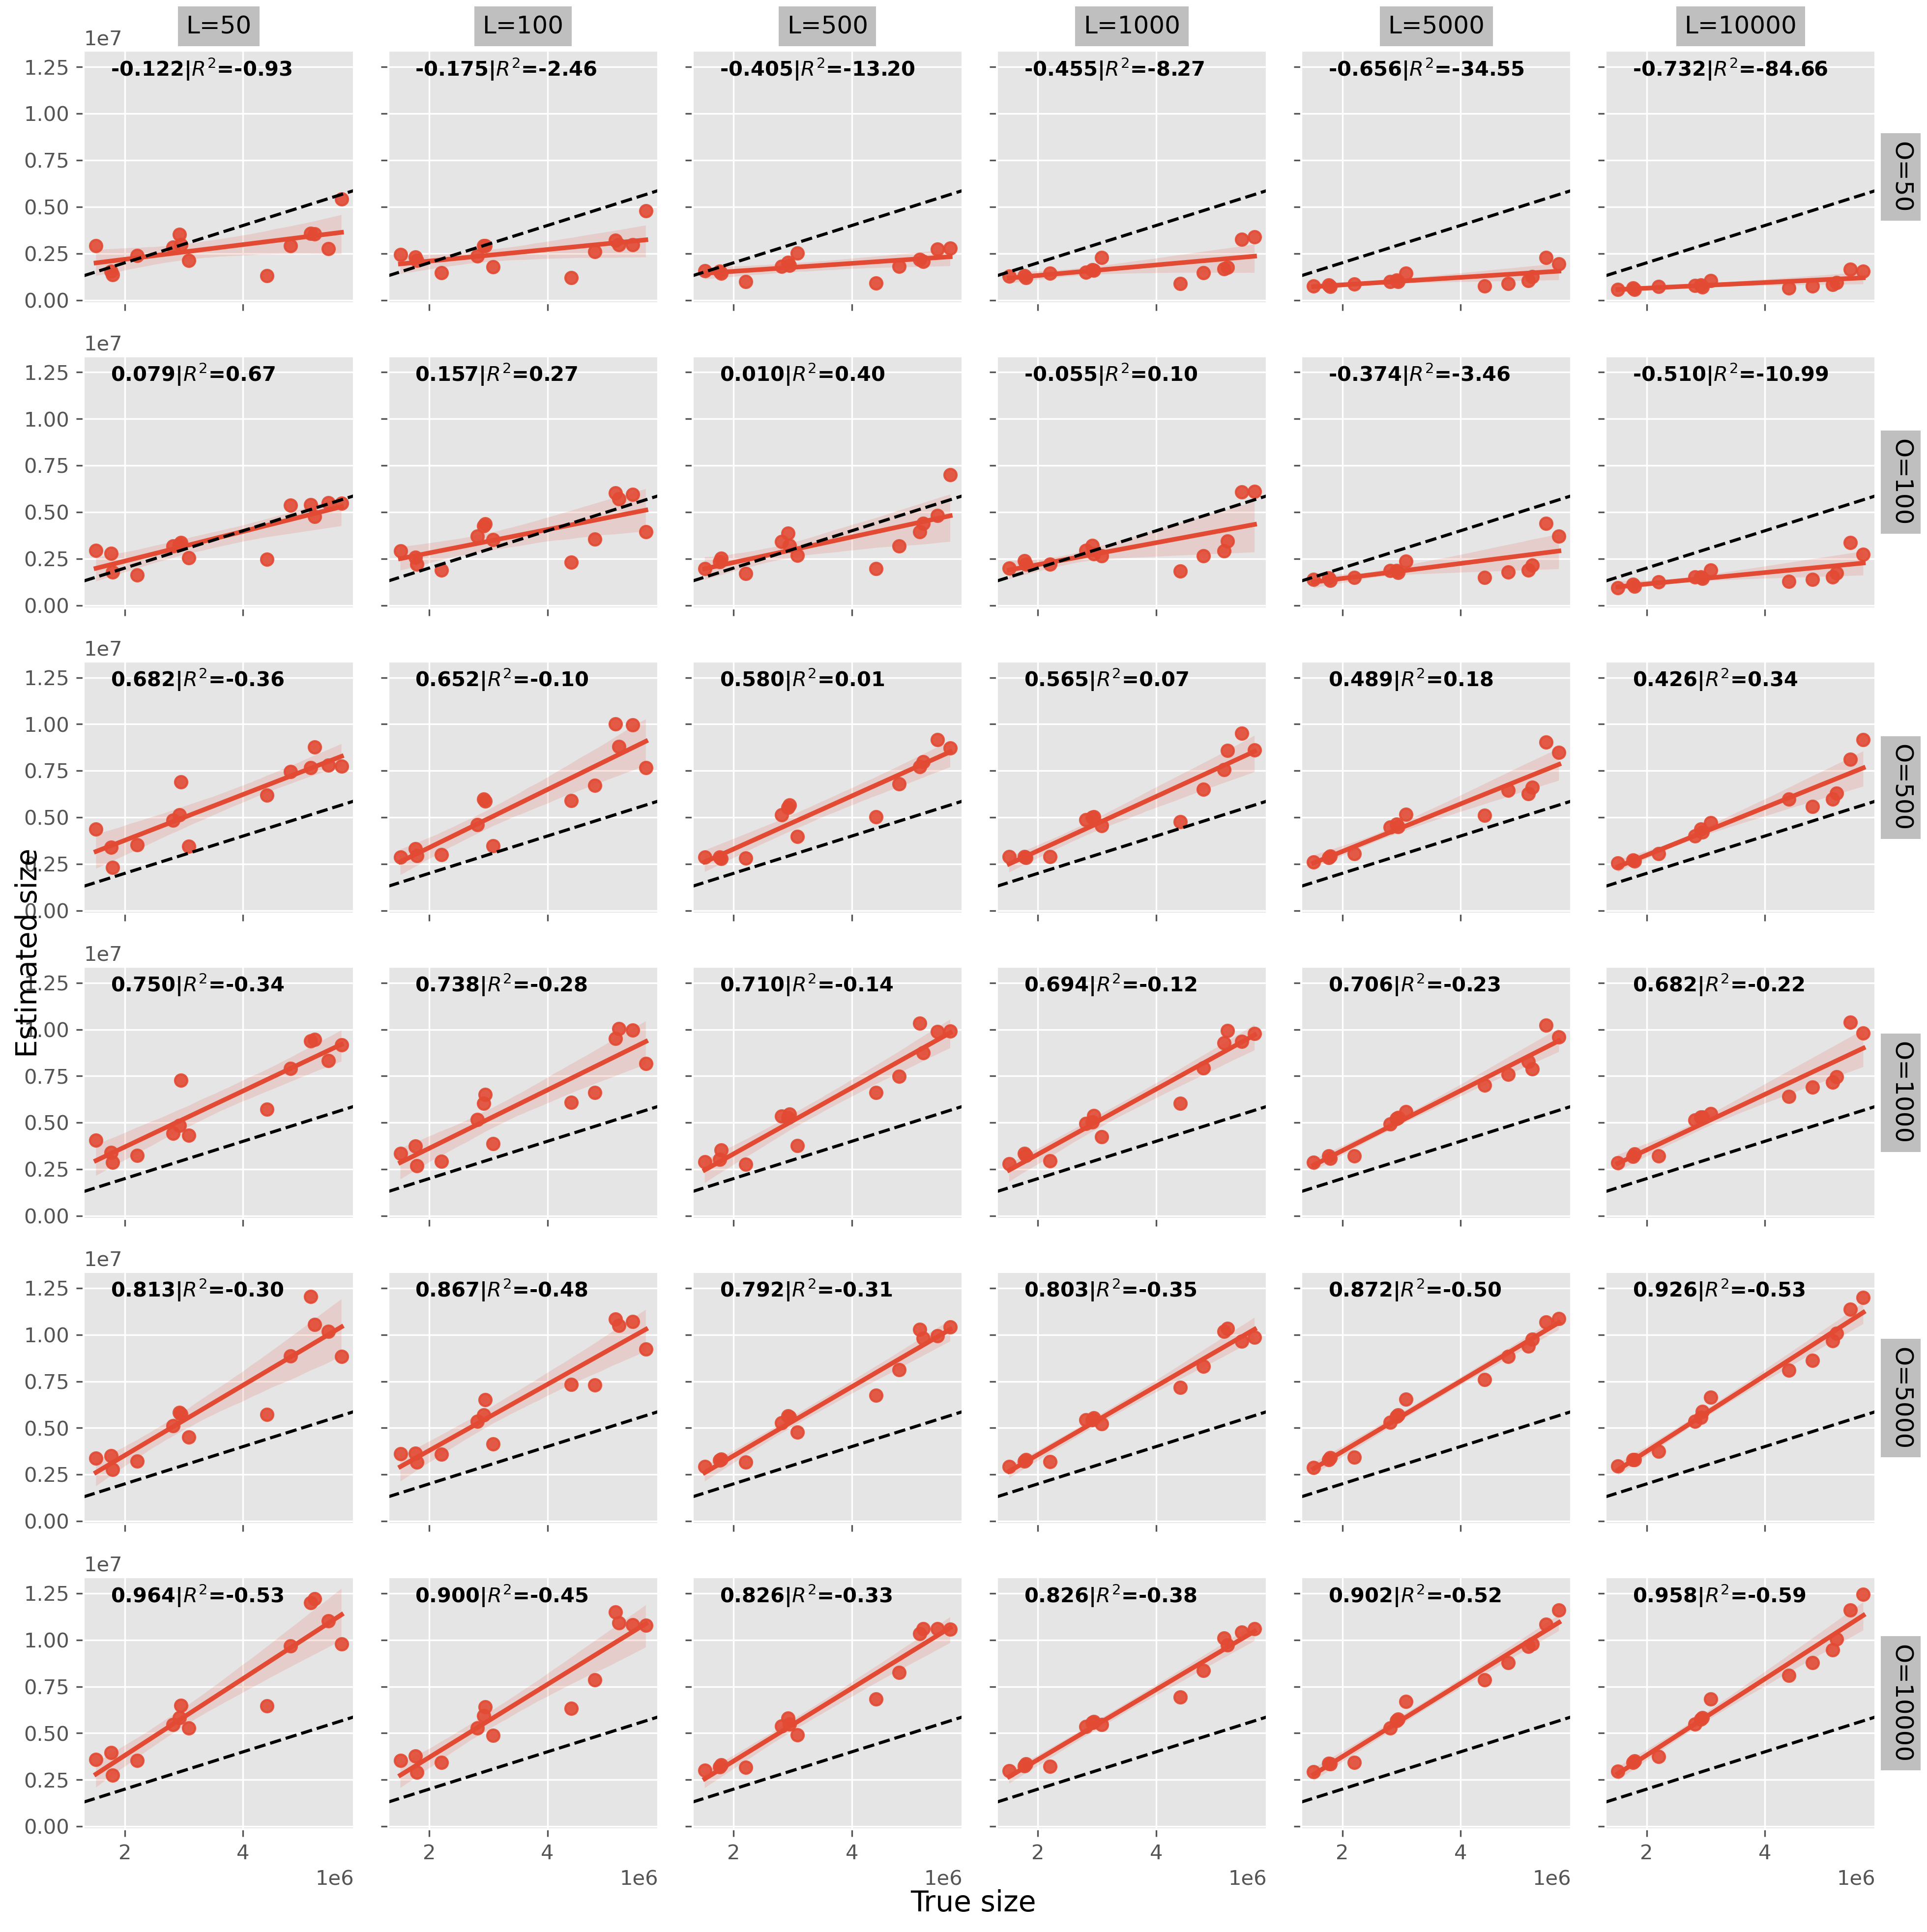

In [33]:
exclude = []  # [50, 500, 5000]
data = twoset_df.query("longest not in @exclude and overlap not in @exclude")
ls = sorted(data["longest"].unique())
os = sorted(data["overlap"].unique())
mean_ratios = []
fig, axes = plt.subplots(
    ncols=len(ls), nrows=len(os), figsize=(13, 13), dpi=300, sharex=True, sharey=True
)

# Add overall column titles
for i, L in enumerate(ls):
    axes[0, i].text(
        0.5,
        1.05,
        f"L={L}",
        ha="center",
        va="bottom",
        bbox=dict(facecolor="grey", edgecolor="none", alpha=0.5),
        transform=axes[0, i].transAxes,
        fontsize=12,
    )

# Add row titles
for j, O in enumerate(os):
    axes[j, -1].text(
        1.05,
        0.5,
        f"O={O}",
        ha="left",
        va="center",
        bbox=dict(facecolor="grey", edgecolor="none", alpha=0.5),
        transform=axes[j, -1].transAxes,
        fontsize=12,
        rotation=270,
    )


for i, L in enumerate(ls):
    for j, O in enumerate(os):
        ax = axes[j, i]
        subdf = data.query("L == @L and O == @O")
        sns.regplot(
            data=subdf, x="true_size", y="estimate", ax=ax, scatter_kws=dict(alpha=0.9)
        )
        # ax.set_title(f"L={L}, O={O}")
        add_identity(ax, color="black", ls="--")
        # ax.set_ylim(1, 1e7)
        # we add text to each plot with mean((est - true)/true)
        diff_df = subdf.query("L == @L and O == @O")
        diff = diff_df["estimate"] - diff_df["true_size"]
        ratio = diff / diff_df["true_size"]
        mean_ratio = ratio.mean()

        # calculate the coefficient of determination for the estimates with respect to the true size
        est_mean = subdf["estimate"].mean()
        # total sum of squares
        ss_tot = ((subdf["estimate"] - est_mean) ** 2).sum()
        # residual sum of squares (difference from the identity line where y = x)
        ss_res = ((subdf["estimate"] - subdf["true_size"]) ** 2).sum()
        # calculate R^2
        r2 = 1 - (ss_res / ss_tot)

        # calculate the mean absolute error
        mae = 1 / len(subdf) * abs(subdf["estimate"] - subdf["true_size"]).sum()
        # calculate the mean squared error
        mse = 1 / len(subdf) * ((subdf["estimate"] - subdf["true_size"]) ** 2).sum()

        mean_ratios.append((L, O, mean_ratio, r2, mae, mse))
        ax.text(
            0.1,
            0.9,
            f"{mean_ratio:.3f}|$R^2$={r2:.2f}",
            transform=ax.transAxes,
            fontweight="bold",
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

# add a single y label to the middle left plot
fig.text(0.0, 0.5, "Estimated size", va="center", rotation="vertical", fontsize=14)
fig.text(0.5, 0.0, "True size", ha="center", fontsize=14)

plt.tight_layout()
# g = sns.relplot(
#     data=data,
#     x="true_size",
#     y="estimate",
#     col="L",
#     row="O",
#     # fit_reg=False,
#     facet_kws=dict(sharex=True, sharey=True),
#     lw=0,
#     alpha=0.1,
# )
# (
#     g.map(
#         sns.lineplot,
#         "true_size",
#         "true_size",
#         color="black",
#         alpha=0.8,
#         lw=1.5,
#         ls="--",
#     ).set(yscale="log")
# )

In [34]:
max_r2 = max(mean_ratios, key=lambda x: x[3])
max_r2

(np.int64(50),
 np.int64(100),
 np.float64(0.0789346477247808),
 np.float64(0.6714872373279919),
 np.float64(581250.8630952381),
 np.float64(606297493051.7306))

In [35]:
best_mae = min(mean_ratios, key=lambda x: x[4])
best_mae

(np.int64(50),
 np.int64(100),
 np.float64(0.0789346477247808),
 np.float64(0.6714872373279919),
 np.float64(581250.8630952381),
 np.float64(606297493051.7306))

In [36]:
best_mse = min(mean_ratios, key=lambda x: x[5])
best_mse

(np.int64(50),
 np.int64(100),
 np.float64(0.0789346477247808),
 np.float64(0.6714872373279919),
 np.float64(581250.8630952381),
 np.float64(606297493051.7306))

In [37]:
# mean ratio closest to zero
closest_zero = min(mean_ratios, key=lambda x: abs(x[2]))
closest_zero

(np.int64(500),
 np.int64(100),
 np.float64(0.010445786683768951),
 np.float64(0.39618527112587365),
 np.float64(893686.7083333333),
 np.float64(1122240001098.935))

#

# Plotting all-v-all overlap results

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def sample_extract(fpath: Path) -> str:
    return fpath.parts[-2]

In [3]:
logfiles = list(Path("param_explore_ava").rglob("*.log"))
# example log file name param_explore_median_logs/tmp/L5000_O10000_AJ292/param_explore_AJ292_L5000_O10000.out
samples = sorted({sample_extract(p) for p in logfiles})

In [4]:
true_sizes = {}
for sample in samples:
    size = int(Path(f"{sample}.gsize").read_text())
    true_sizes[sample] = size

In [5]:
estimates = []

for log in logfiles:
    sample = sample_extract(log)
    n = int(log.parts[-3][1:])
    N = int(log.name.rsplit("_")[-1].split(".")[0][1:])

    strategy = log.parts[-4]
    if strategy == "long" and N > 0:
        continue
    true_size = true_sizes[sample]
    text = log.read_text()
    last_line = text.splitlines()[-1]
    est = int(last_line.strip())
    rel_size = est / true_size
    rel_err = (est - true_size) / true_size * 100
    estimates.append((sample, n, N, strategy, est, true_size, rel_size, rel_err))

In [6]:
df = pd.DataFrame(
    estimates,
    columns=[
        "sample",
        "n_reads",
        "replicate",
        "strategy",
        "estimate",
        "true_size",
        "rel_size",
        "rel_err",
    ],
)
df["method"] = "lrge"


<Axes: xlabel='n_reads', ylabel='rel_err'>

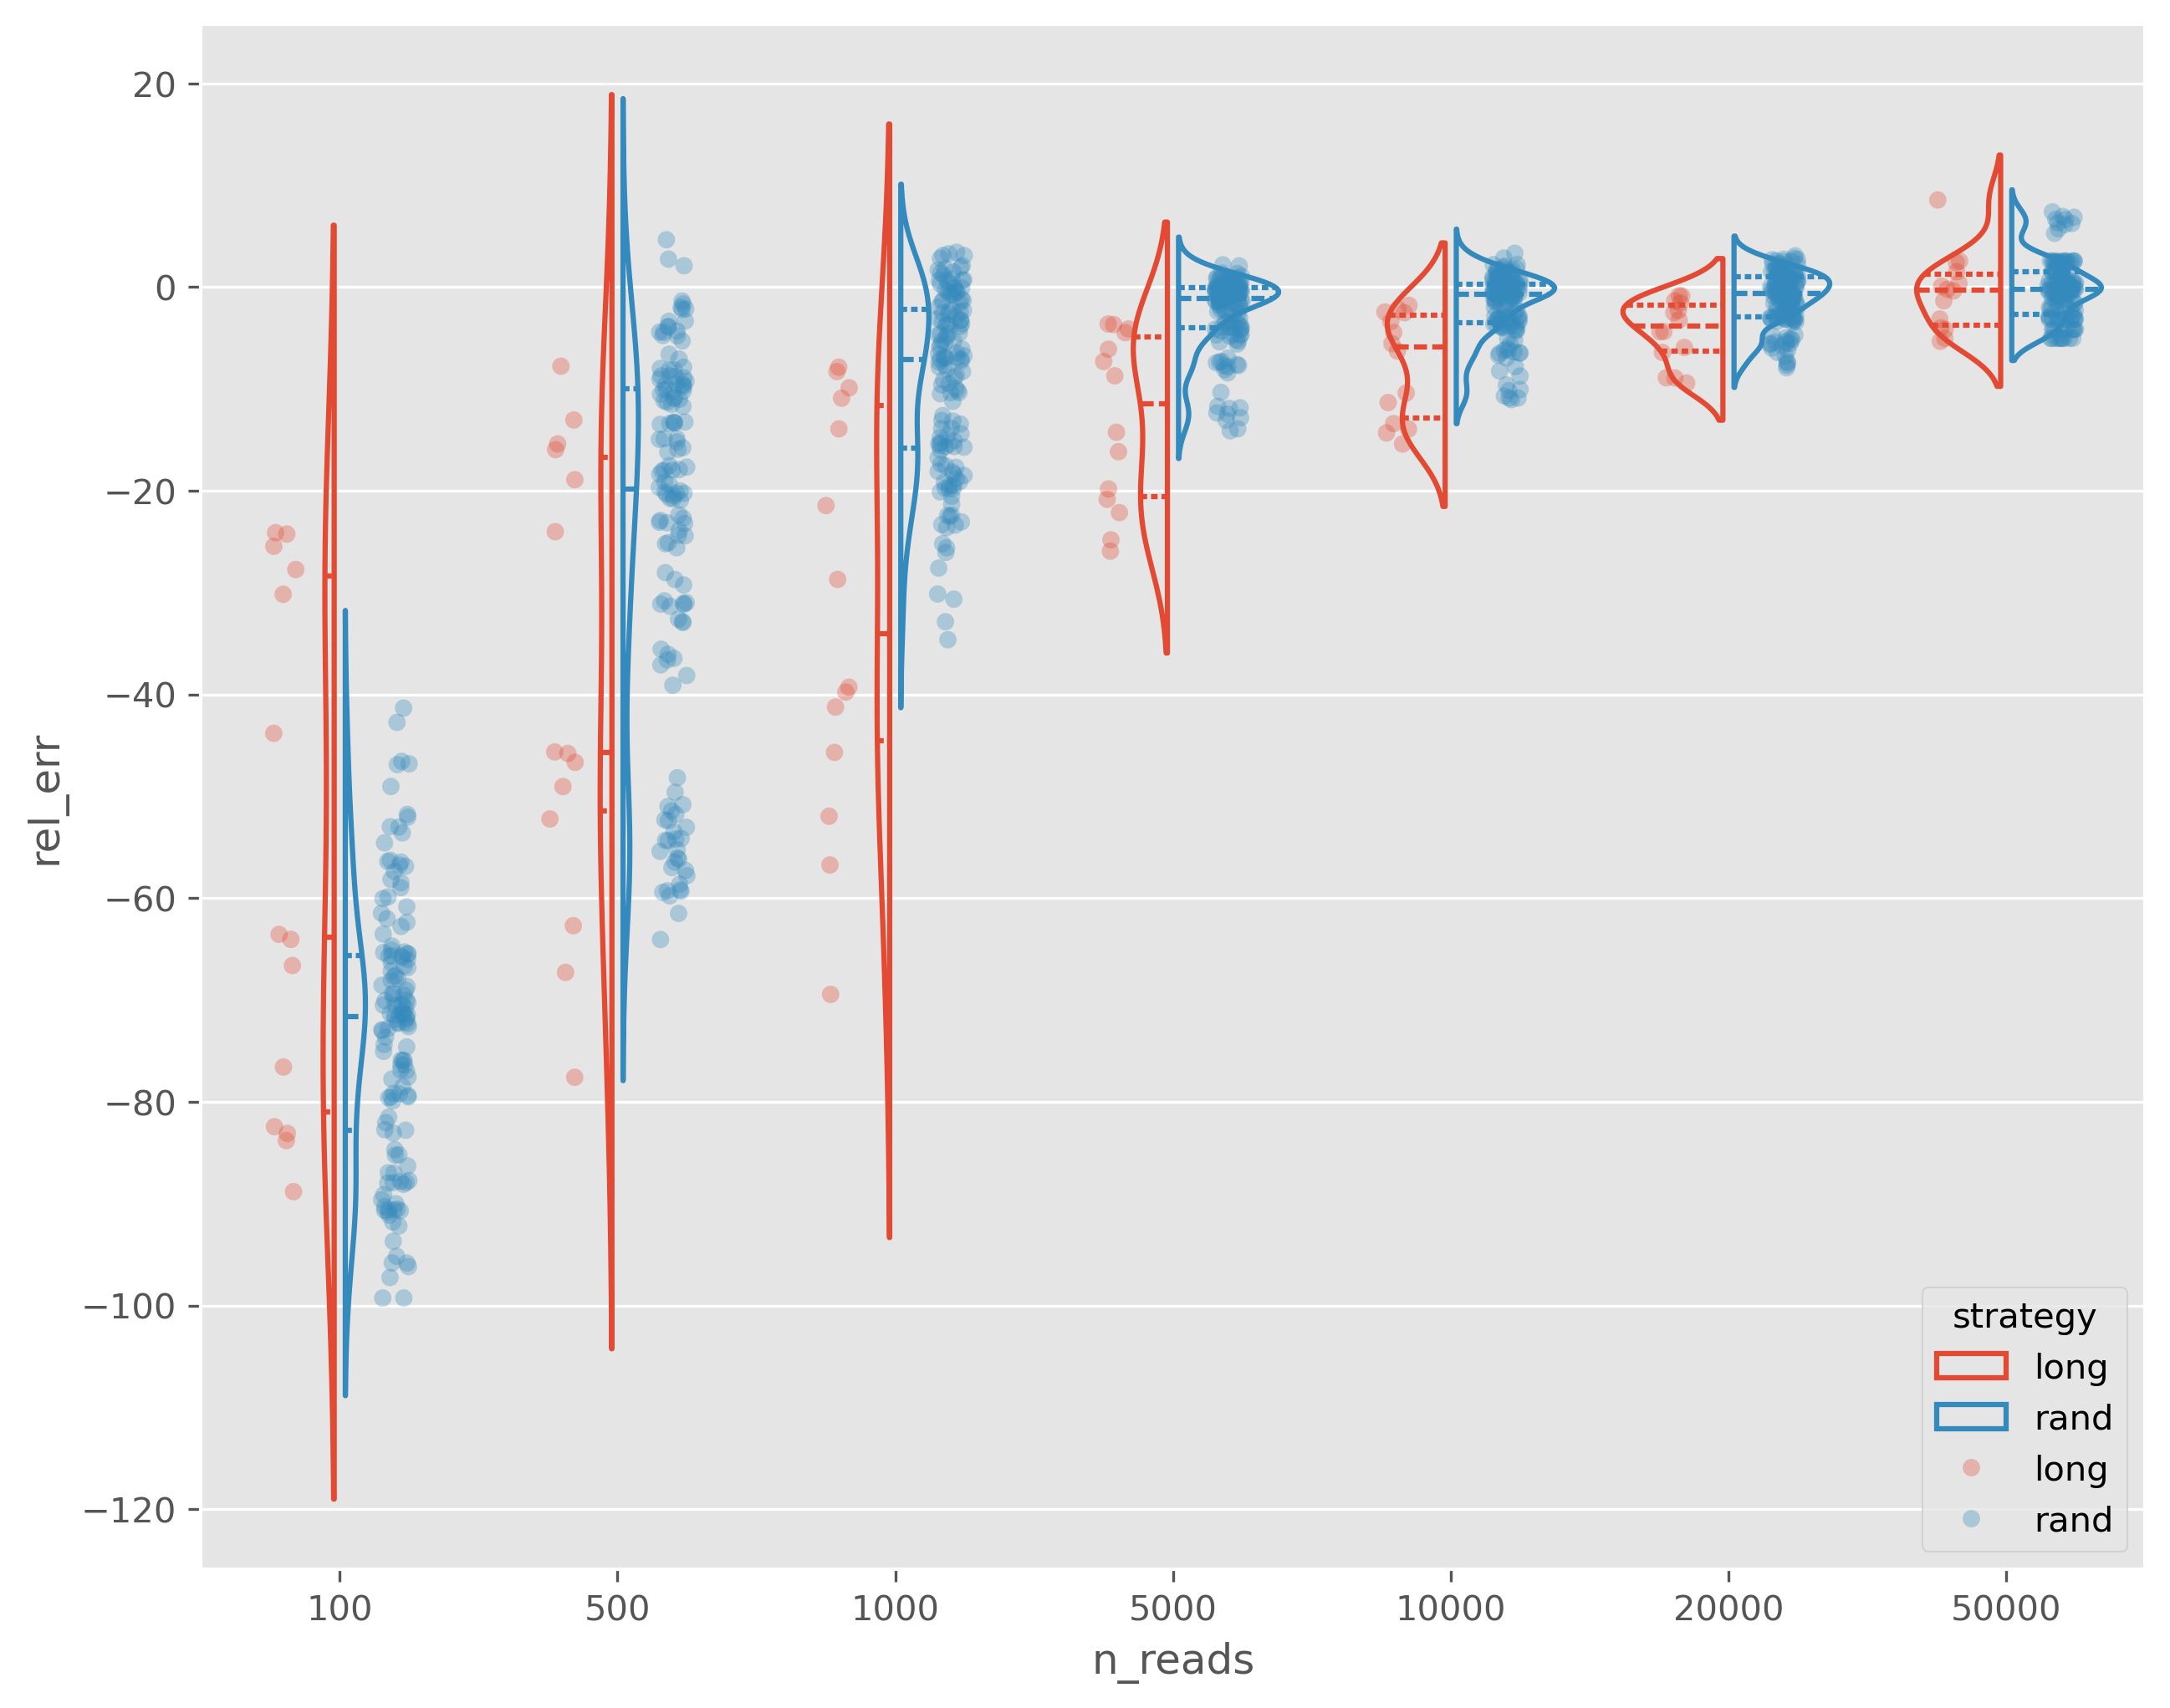

In [44]:
fig, ax = plt.subplots(dpi=300, figsize=(10, 8))

no_plasmids = [
    "AJ292",
    "AMtb_1",
    "ATCC_19119",
    "ATCC_33560",
    "ATCC_35221",
    "ATCC_35897",
    "ATCC_BAA-679",
    "MMC234",
    "RDH275"
]

data = df#.query("sample in @no_plasmids")

sns.violinplot(
    data=data,
    x="n_reads",
    y="rel_err",
    ax=ax,
    inner="quartile",
    hue="strategy",
    fill=False,
    cut=2,
    split=True,
    gap=0.1,
)
sns.stripplot(
    data=data, x="n_reads", y="rel_err", ax=ax, hue="strategy", dodge=True, alpha=0.33
)

In [78]:
data.query("sample == 'AJ292' and n_reads == 50000 and strategy == 'rand'")

,sample,n_reads,replicate,strategy,estimate,true_size,rel_size,rel_err
158,AJ292,50000,6,rand,11410018,5445132,2.095453,109.545297
159,AJ292,50000,9,rand,11410018,5445132,2.095453,109.545297
160,AJ292,50000,5,rand,11410018,5445132,2.095453,109.545297
161,AJ292,50000,4,rand,11410018,5445132,2.095453,109.545297
162,AJ292,50000,1,rand,11379838,5445132,2.089910,108.991040
163,AJ292,50000,3,rand,11410018,5445132,2.095453,109.545297
164,AJ292,50000,2,rand,11379838,5445132,2.089910,108.991040
165,AJ292,50000,8,rand,11410018,5445132,2.095453,109.545297
166,AJ292,50000,0,rand,11379838,5445132,2.089910,108.991040
167,AJ292,50000,7,rand,11410018,5445132,2.095453,109.545297


In [37]:
with open("../data/references/ATCC_25922__202309.fa") as f:
    seq = ""
    for line in f:
        if line.startswith(">"):
            print(len(seq))
            print(line.strip())
            seq = ""
        seq += line.strip()
    print(len(seq))

0
>chromosome circular=true
5132245
>plasmid_1 circular=true
48512
>plasmid_2 circular=true
24209
>plasmid_3 circular=true
3197
>plasmid_4 circular=true
1943


# Looking at the Mash estimates

In [1]:
import pandas as pd

In [8]:
mash = pd.read_csv("mash_estimates.csv")
mash

,sample,sketch_size,min_copies,estimate
0,ATCC_35897,10000,4,3030810
1,ATCC_19119,10000,4,3107320
2,BPH2947,10000,4,3220840
3,ATCC_10708,10000,4,5263600
4,KPC2,10000,4,7432100
...,...,...,...,...
443,AMtb_1,100000,8,4431640
444,MMC234,100000,8,2209750
445,ATCC_33560,100000,8,1794050
446,ATCC_BAA-679,100000,8,2956680


In [9]:
# get true sizes from the true_sizes dict
mash["true_size"] = [true_sizes[sample] for sample in mash["sample"]]
mash["rel_size"] = mash["estimate"] / mash["true_size"]
mash["rel_err"] = (mash["estimate"] - mash["true_size"]) / mash["true_size"] * 100
mash["method"] = "mash"


(0.5, 2.0)

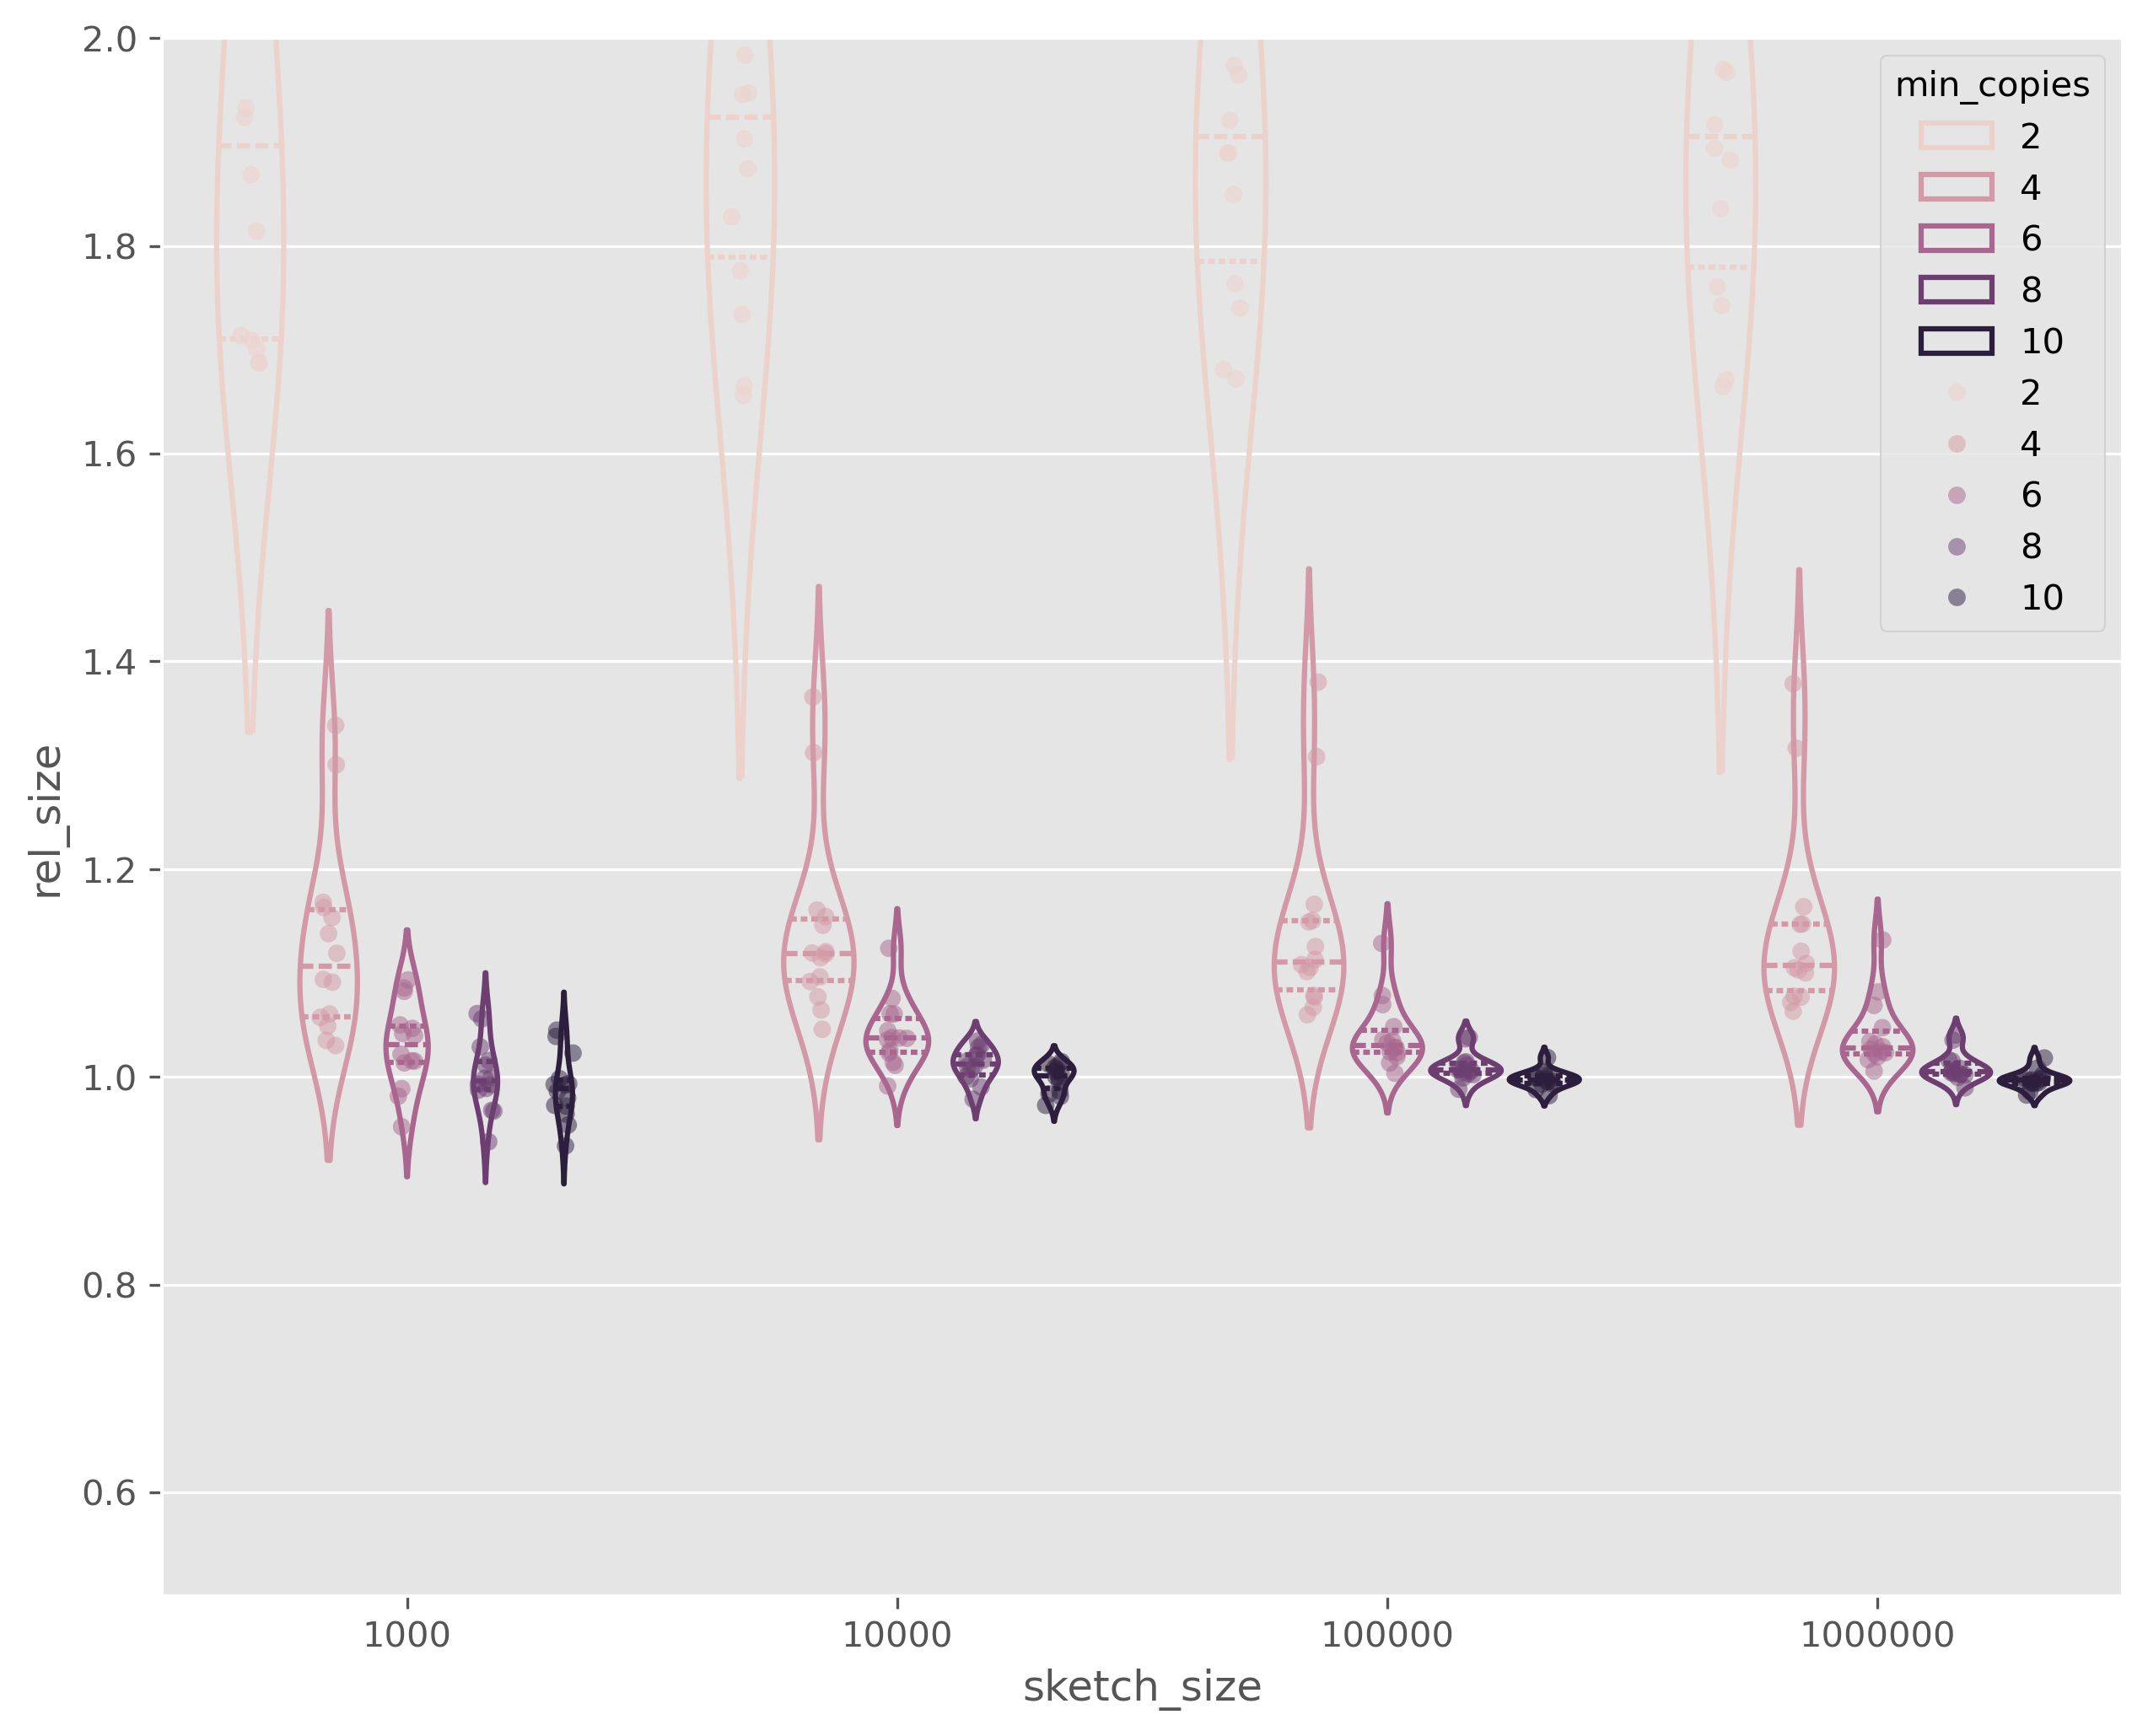

In [27]:
fig, ax = plt.subplots(dpi=300, figsize=(10, 8))

# use min copies that are a multiple of 2
data = mash.query("min_copies % 2 == 0")

sns.violinplot(
    data=data,
    x="sketch_size",
    y="rel_size",
    ax=ax,
    inner="quartile",
    hue="min_copies",
    fill=False,
    split=False,
    gap=0.1,
)
sns.stripplot(
    data=data, x="sketch_size", y="rel_size", ax=ax, hue="min_copies", dodge=True, alpha=0.5
)

# ax.set_yscale("symlog")
# yticks = [-100, -50, -10, 0, 10, 50, 100, 1000]
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticks)
ax.set_ylim(0.5, 2.0)


In [2]:
gscope = pd.read_csv("../results/genomescope_estimates.csv")
gscope

,sample,kmer_size,min_copies,estimate
0,ATCC_35897,19,4,2806903
1,ATCC_19119,19,4,2904738
2,BPH2947,19,4,3390340
3,ATCC_10708,19,4,4847902
4,KPC2,19,4,5845672
...,...,...,...,...
624,AMtb_1,31,5,4318773
625,MMC234,31,5,2059293
626,ATCC_33560,31,5,1636551
627,ATCC_BAA-679,31,5,2880341


In [10]:
gscope["true_size"] = [true_sizes[sample] for sample in gscope["sample"]]
gscope["rel_size"] = gscope["estimate"] / gscope["true_size"]
gscope["rel_err"] = (gscope["estimate"] - gscope["true_size"]) / gscope["true_size"] * 100
gscope["method"] = "genomescope2"

<Axes: xlabel='kmer_size', ylabel='rel_size'>

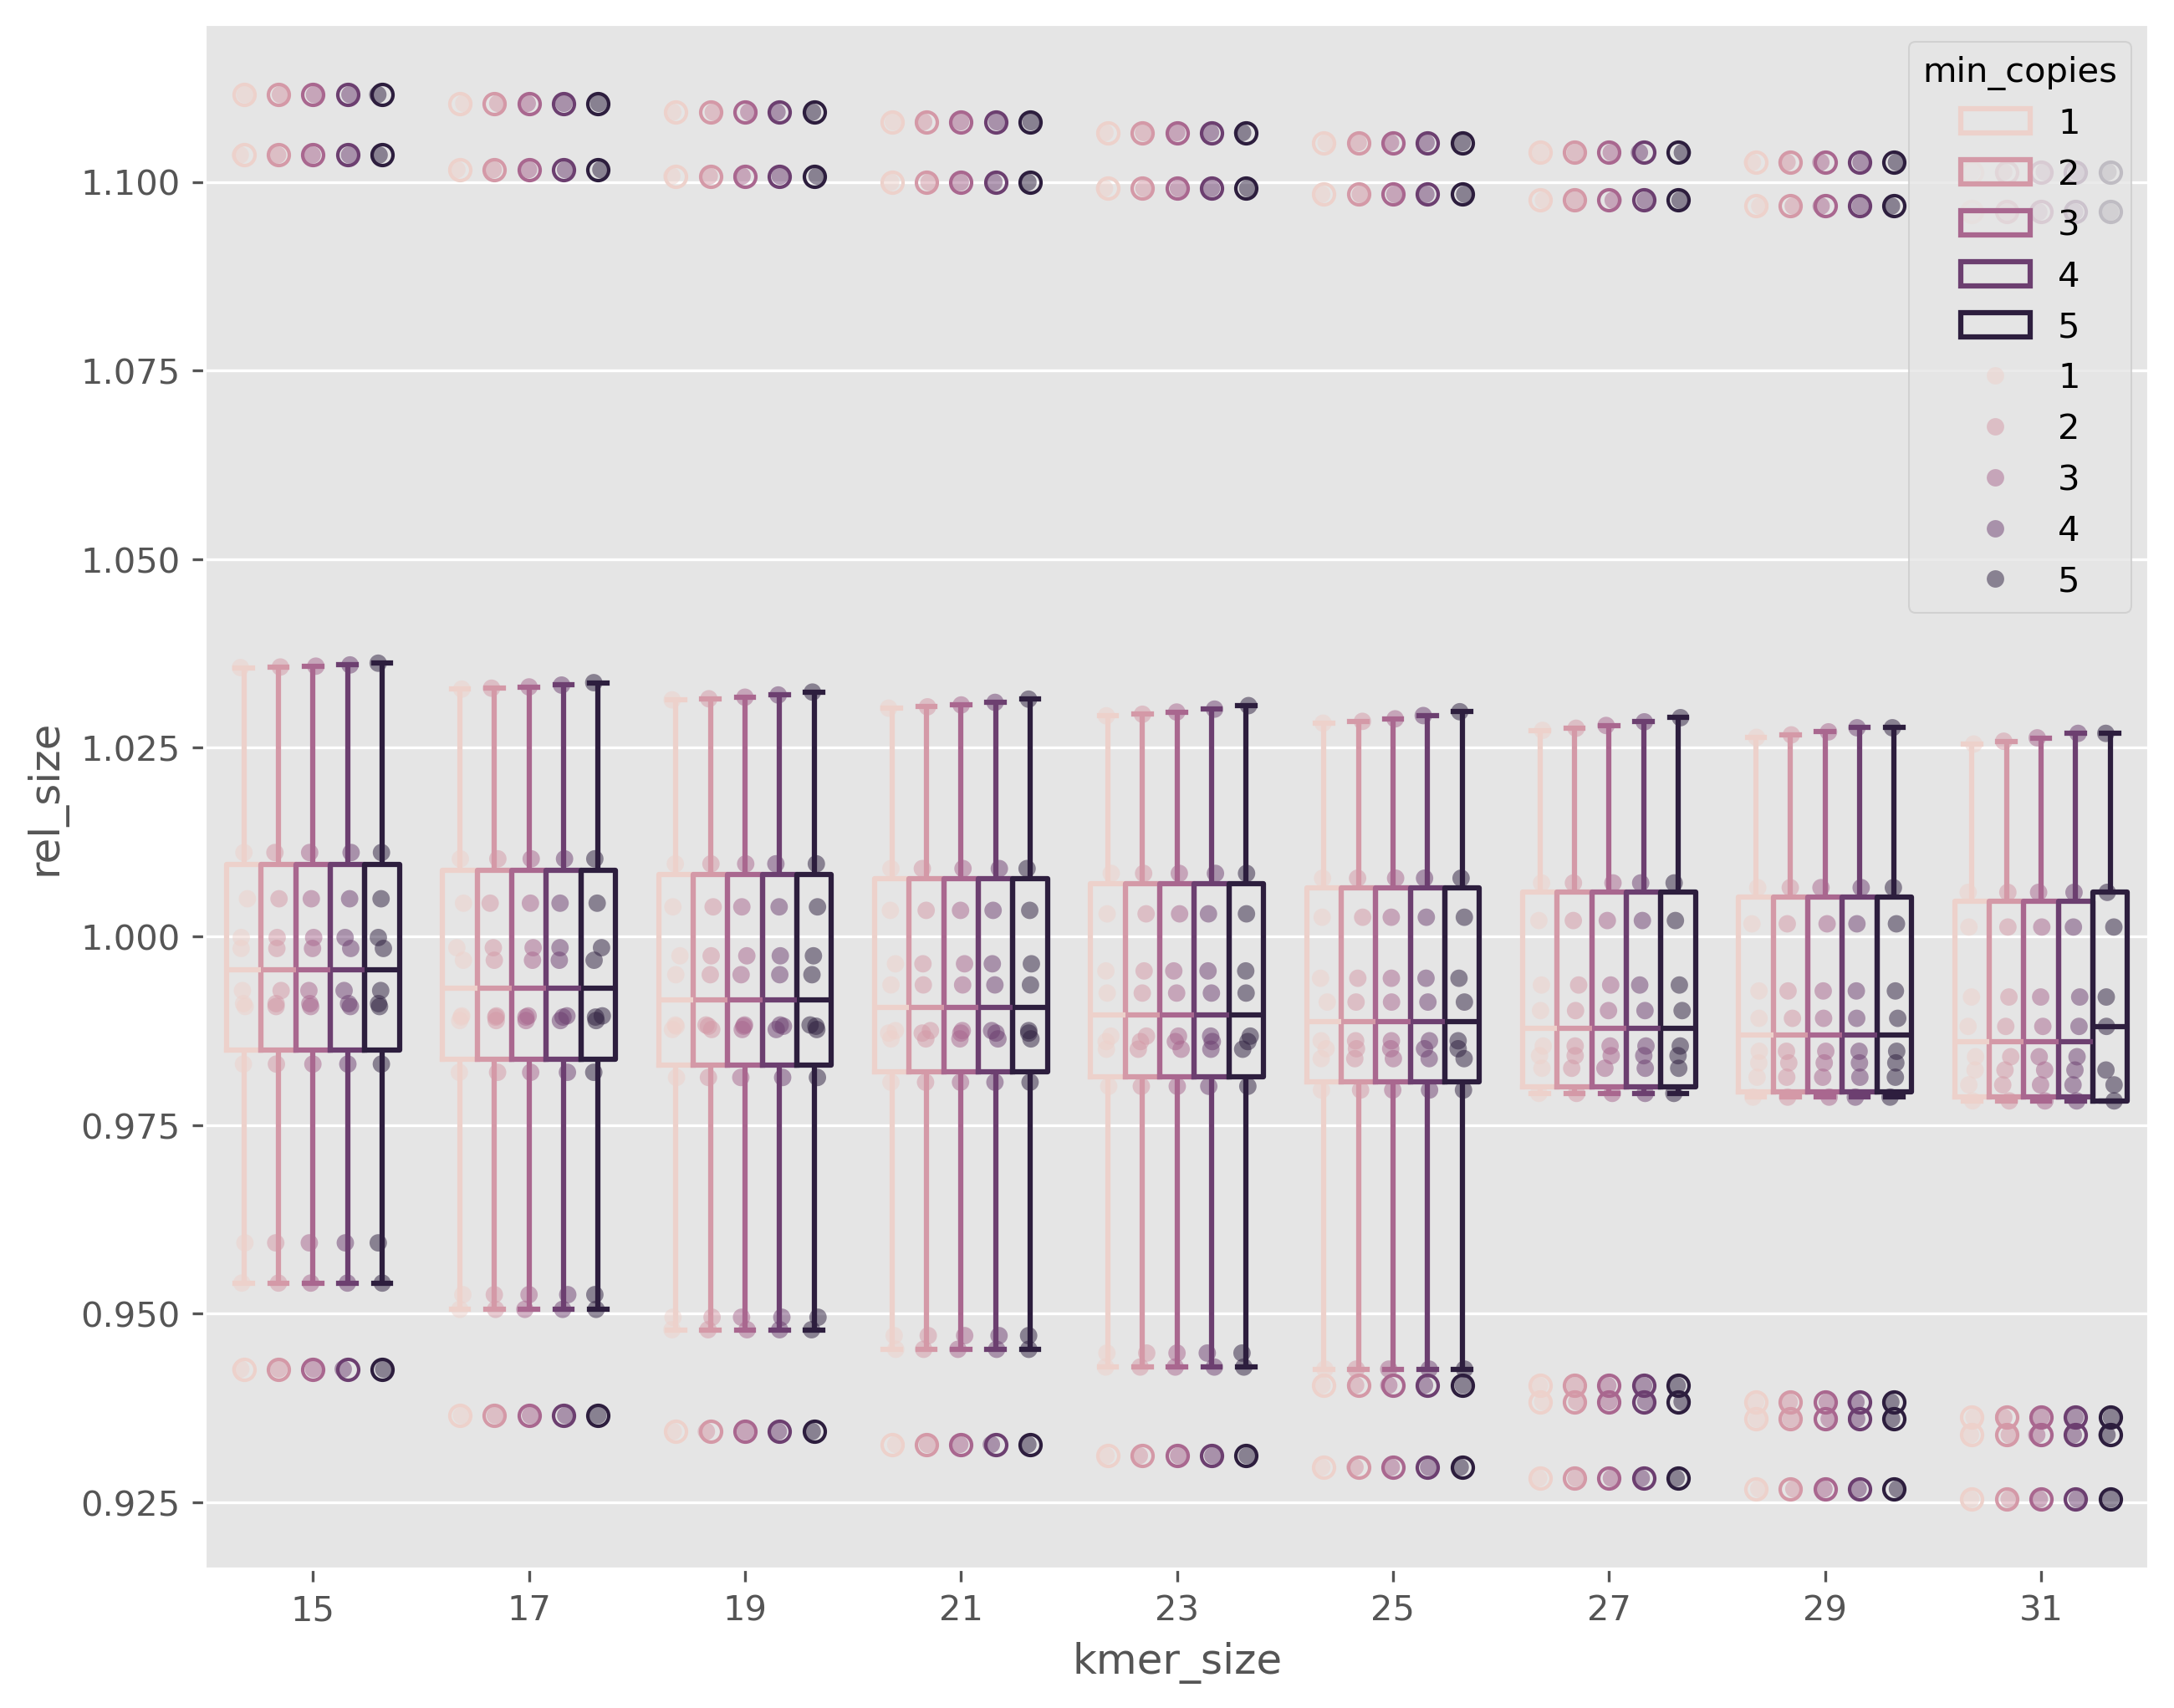

In [13]:
fig, ax = plt.subplots(dpi=300, figsize=(10, 8))

# use min copies that are a multiple of 2
data = gscope#.query("min_copies % 2 == 0")

x = "kmer_size"
y = "rel_size"
hue = "min_copies"

sns.boxplot(
    data=data,
    x=x,
    y=y,
    ax=ax,
    # inner="quartile",
    hue=hue,
    fill=False,
    # split=False,
    # gap=0.1,
)
sns.stripplot(
    data=data, x=x, y=y, ax=ax, dodge=True, alpha=0.5, hue=hue
)

# ax.set_yscale("symlog")
# yticks = [-100, -50, -10, 0, 10, 50, 100, 1000]
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticks)

In [12]:
best_mash_sketch_size = 100_000
best_mash_min_copies = 10

best_mash = mash.query("sketch_size == @best_mash_sketch_size and min_copies == @best_mash_min_copies")

best_gscope_kmer_size = 15
best_gscope_min_copies = 1

best_gscope = gscope.query("kmer_size == @best_gscope_kmer_size and min_copies == @best_gscope_min_copies")

In [13]:
# merge best mash and gscope, dropping columns that are not shared
best = pd.concat([best_mash, best_gscope], join="inner")

In [14]:
best_lrge_n_reads = 50000
best_lrge_strategy = "rand"
best_lrge = df.query("n_reads == @best_lrge_n_reads and strategy == @best_lrge_strategy")
# merge best with best_lrge
best = pd.concat([best, best_lrge])

In [15]:
def r2(df) -> float:
    """calculate the coefficient of determination for the estimates with respect to the 
    true size. If the df has replicates, the mean estimate for each sample is used.
    """
    subdf = df.groupby("sample").mean(numeric_only=True)
    est_mean = subdf["estimate"].mean()
    # total sum of squares
    ss_tot = ((subdf["estimate"] - est_mean) ** 2).sum()
    # residual sum of squares (difference from the identity line where y = x)
    ss_res = ((subdf["estimate"] - subdf["true_size"]) ** 2).sum()
    # calculate R^2
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [16]:
from typing import List

# colourblind-friendly palette from colour universal design (CUD)
# https://jfly.uni-koeln.de/color/
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())


def cud(n: int = len(cud_palette), start: int = 0) -> List[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]

Text(0.5, 0, '')

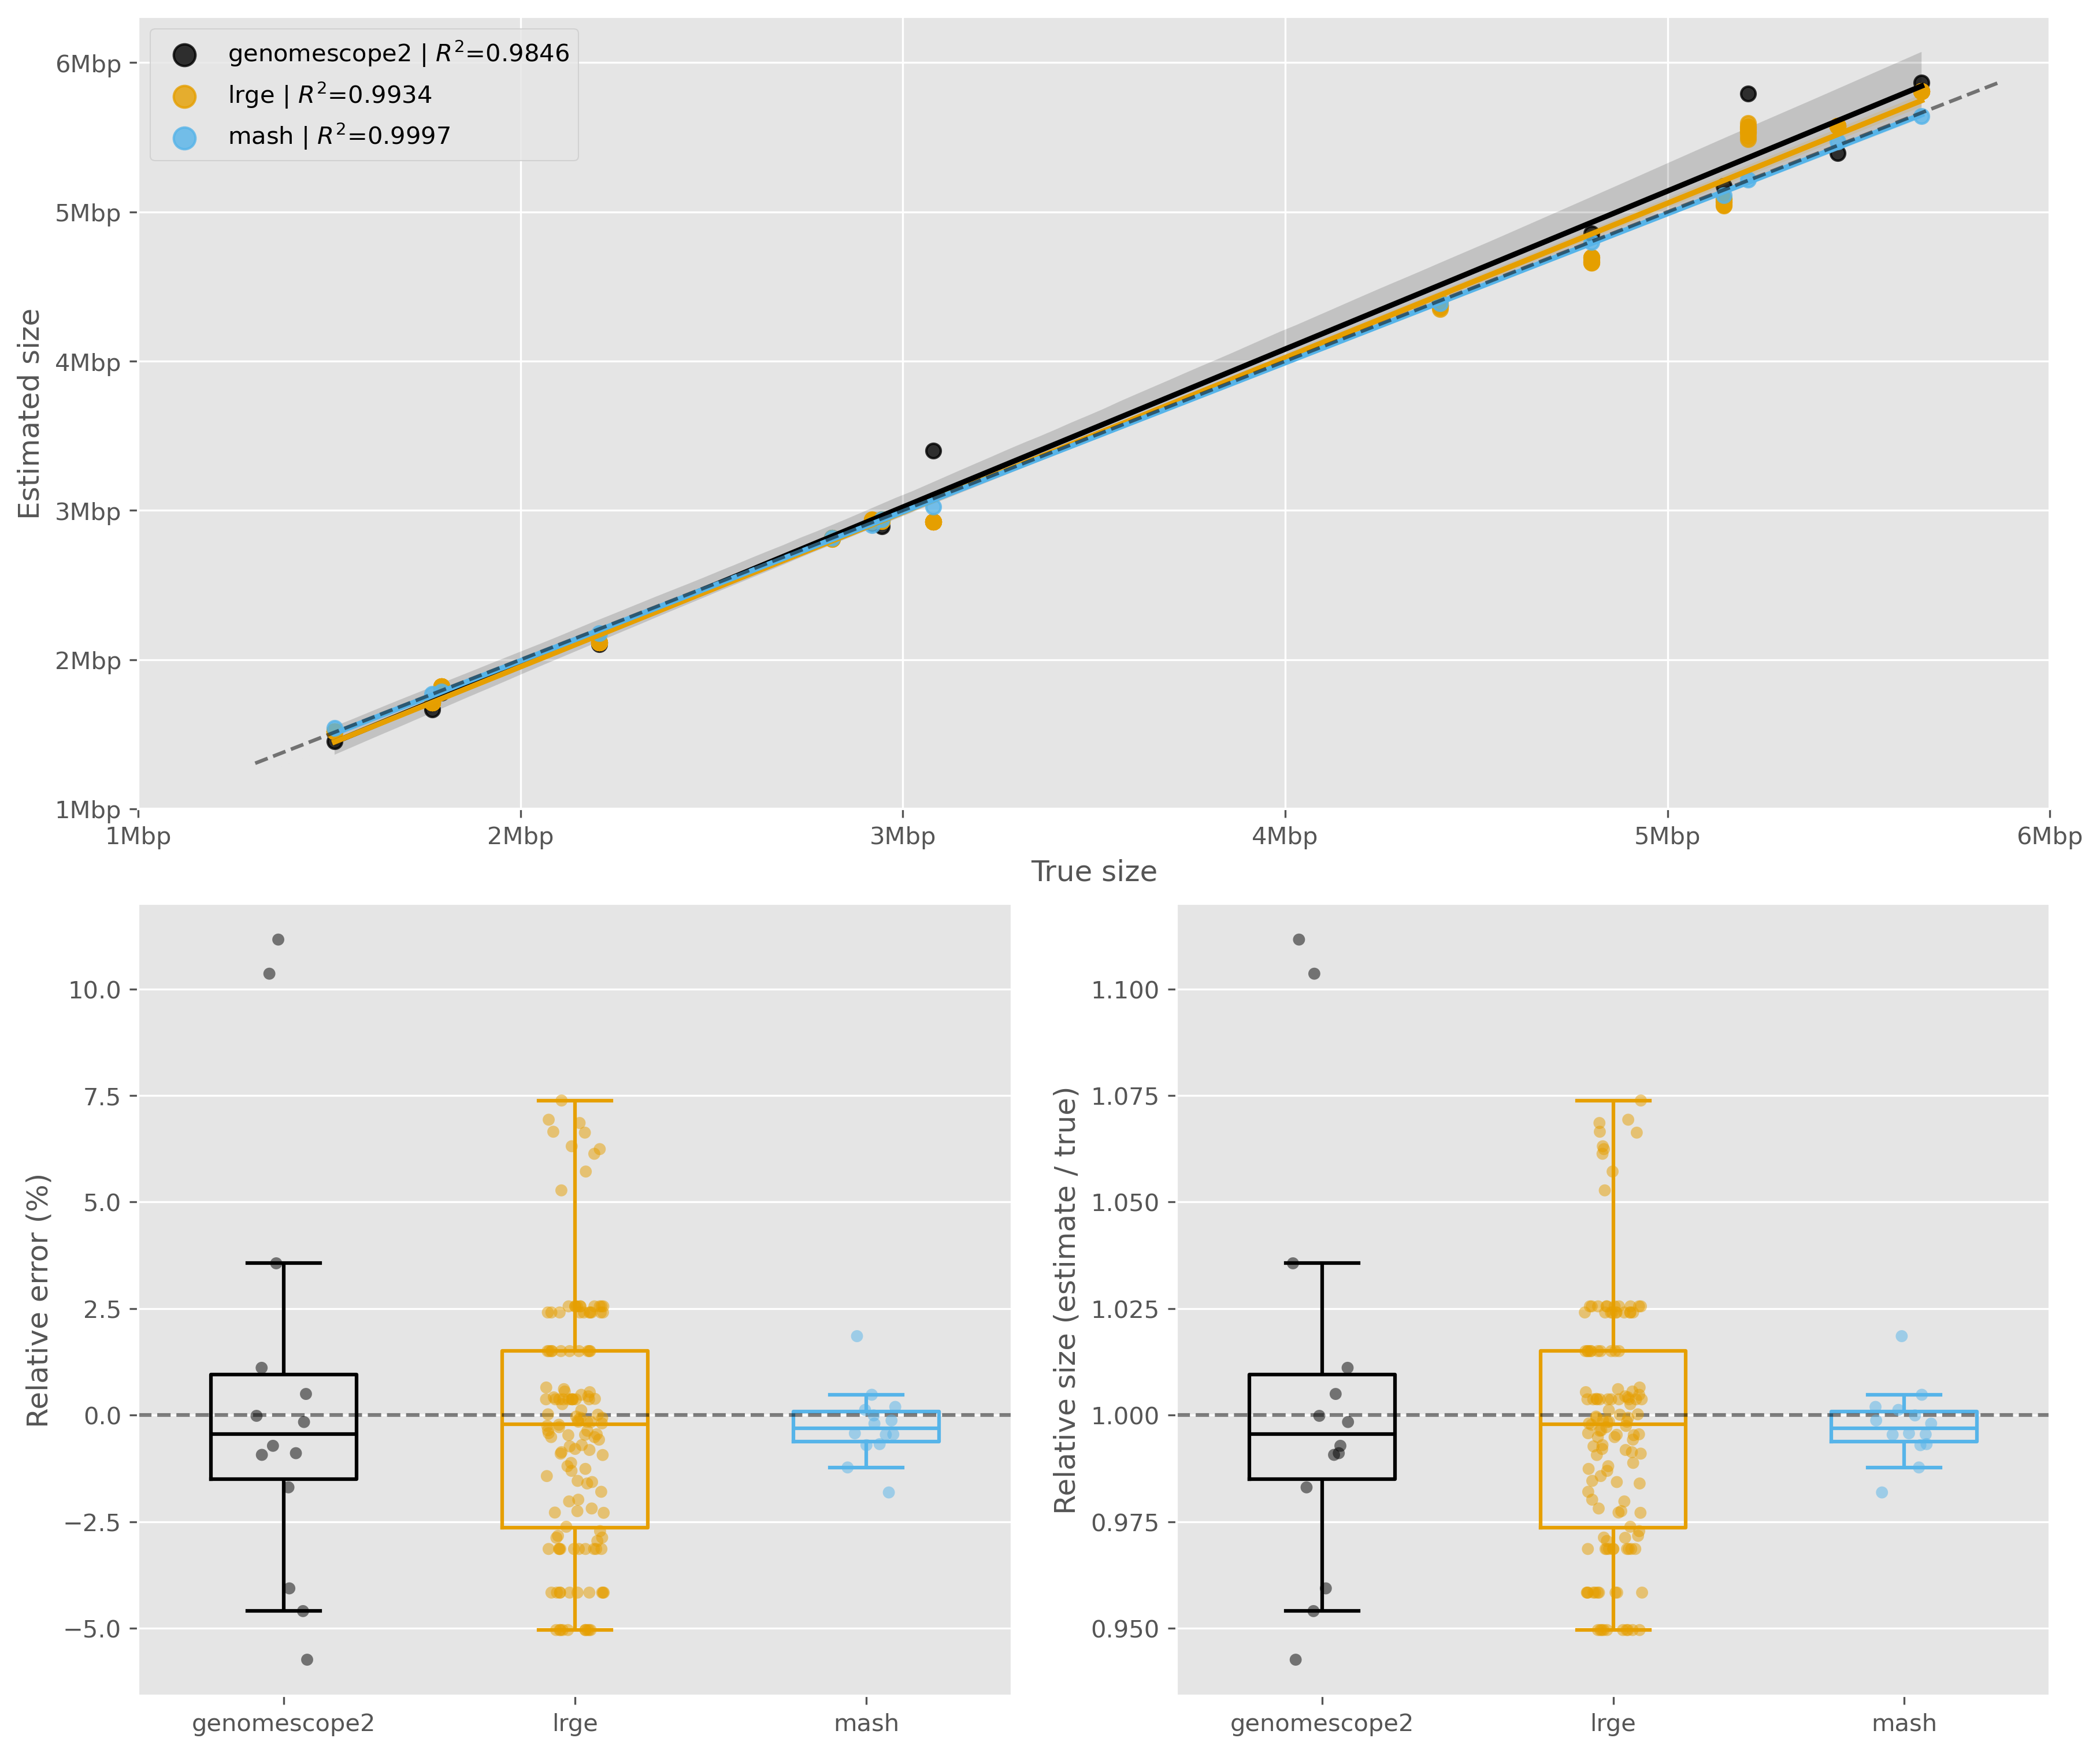

In [24]:
from matplotlib.gridspec import GridSpec
# plt.style.use("seaborn-v0_8")
fig = plt.figure(figsize=(12, 10), dpi=300, layout="constrained")
# make two rows, the tope row with 1 column and the bottom row with 2 columns
gs = GridSpec(2, 2, figure=fig)
top_ax = fig.add_subplot(gs[0, :])
bleft_ax = fig.add_subplot(gs[1, 0])
bright_ax = fig.add_subplot(gs[1, 1])
methods = sorted(best["method"].unique())
palette = cud(len(methods))

# ============================
# plot the top plot
x = "true_size"
y = "estimate"
hue = "method"
r2_values = []
for i, method in enumerate(methods):
    subdf = best.query("method == @method")
    colour = palette[i]
    sns.regplot(data=subdf, x=x, y=y, ax=top_ax, label=method, color=colour)
    # calculate r^2 for the top plot and add text to the top plot
    r2_val = r2(subdf)
    r2_values.append((method, r2_val))

add_identity(top_ax, color="black", ls="--", alpha=0.5)
top_ax.set_xlabel("True size")
top_ax.set_ylabel("Estimated size")
# add the r2 values to the legend label for each method
top_ax.legend()
handles, labels = top_ax.get_legend_handles_labels()
top_ax.legend(handles, [f"{label} | $R^2$={r2:.4f}" for label, r2 in r2_values], markerscale=1.5, fontsize=10, loc="upper left")
ticks = [i * 1e6 for i in range(1, 7)]
top_ax.set_xticks(ticks)
top_ax.set_xticklabels([f"{i}Mbp" for i in range(1, 7)])
top_ax.set_yticks(ticks)
top_ax.set_yticklabels([f"{i}Mbp" for i in range(1, 7)])
# ============================
# plot the bottom left plot
x = "method"
y = "rel_err"
hue = "method"
shared_kwargs = dict(
    x=x, hue=hue, y=y, hue_order=methods, order=methods, ax=bleft_ax, data=best, palette=palette
)
box_kwargs = dict(**shared_kwargs, fill=False, width=0.5, fliersize=0)
sns.boxplot(**box_kwargs)
strip_kwargs = dict(**shared_kwargs, dodge=False, alpha=0.5)
sns.stripplot(**strip_kwargs)
bleft_ax.axhline(0, color="black", ls="--", alpha=0.5)
bleft_ax.set_ylabel("Relative error (%)")
bleft_ax.set_xlabel("")
# ============================
# plot the bottom right plot
y = "rel_size"
shared_kwargs.update(dict(y=y, ax=bright_ax))
box_kwargs.update(**shared_kwargs)
sns.boxplot(**box_kwargs)
strip_kwargs.update(**shared_kwargs)
sns.stripplot(**strip_kwargs)
bright_ax.axhline(1, color="black", ls="--", alpha=0.5)
bright_ax.set_ylabel("Relative size (estimate / true)")
bright_ax.set_xlabel("")

In [96]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [59]:
from collections import defaultdict, Counter

In [68]:
n_olaps = Counter()
sample = "AMtb_1"
ps = list(Path(f"/data/scratch/projects/punim2009/genome_size/param_explore_ava/rand/n50000/{sample}/.lrge").glob("*.paf"))
with open(ps[0]) as f:
    for line in f:
        n_olaps[line.split("\t")[5]] += 1

<Axes: ylabel='Count'>

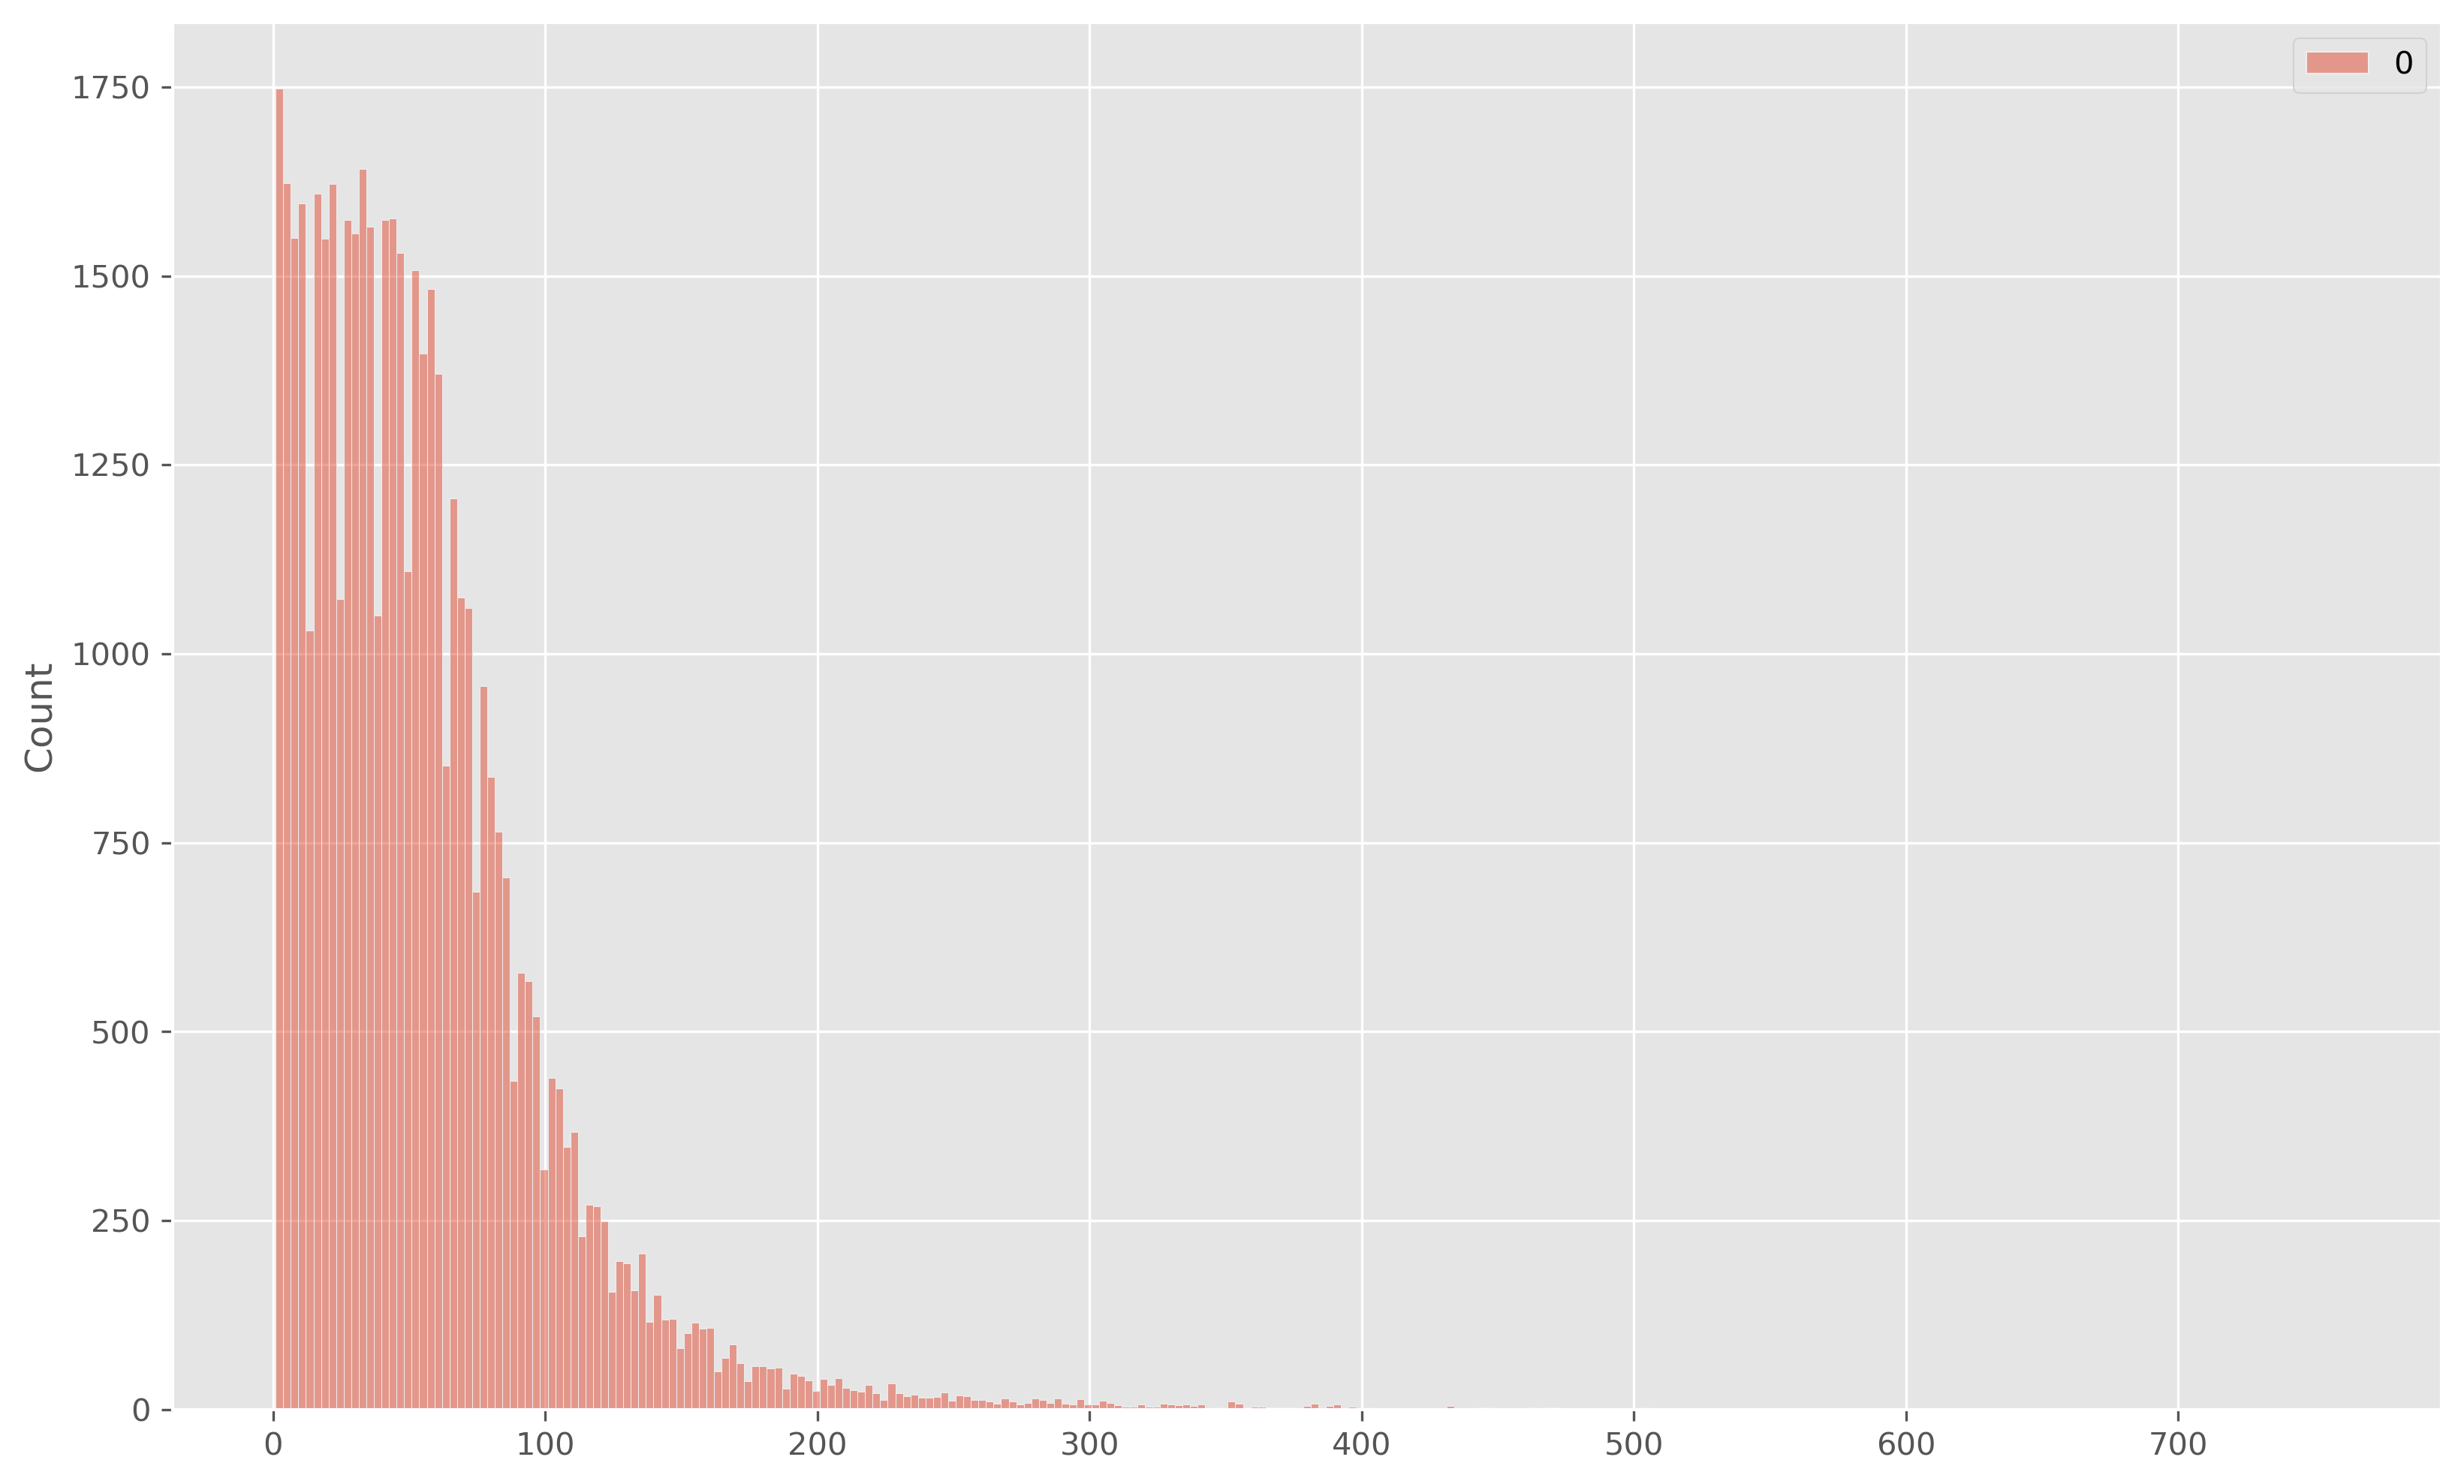

In [69]:
sns.histplot(n_olaps.values())

In [71]:
pd.Series(n_olaps).describe()

count    49046.000000
mean        56.459018
std         50.317712
min          1.000000
25%         23.000000
50%         47.000000
75%         74.000000
max        759.000000
dtype: float64

In [67]:
n_olaps.most_common(10)

[('f0f033f2-3df4-4ce7-b593-dd7ce62e07e6', 2368),
 ('e0504670-dd36-4a46-b70e-7bb1e559fd6b', 2253),
 ('f2c98f11-529b-40e4-9af8-afd948b8c787', 2189),
 ('f2b663d5-d01b-432d-b9b1-56182f64e0a3', 2068),
 ('c4645fb1-a1f4-4037-aaa6-17ef729666bf', 2005),
 ('b59fa235-5535-4f0c-888b-d6b8fd58289c', 1986),
 ('f6a7f10d-c70e-44d6-9dbb-e3aac32afa6c', 1802),
 ('e83db89d-6221-47a1-af64-770fb9259fa4', 1770),
 ('e7e8febb-cd40-42fa-8dbf-d5fe2db2fcc8', 1703),
 ('dbe52fa4-2ae5-425f-ac14-005264a02e13', 1690)]

In [86]:
# as a santiy check, see what the total number of overlaps is for each read depending on 
# whether we use the qname or tname column in the PAF file
n_olaps_qname = Counter()
n_olaps_tname = Counter()
for p in ps:
    with open(p) as f:
        for line in f:
            n_olaps_qname[line.split("\t")[0]] += 1
            n_olaps_tname[line.split("\t")[5]] += 1

In [103]:
diffs = []
for k in n_olaps_qname:
    diffs.append(abs(n_olaps_qname[k] - n_olaps_tname[k]))

In [104]:
len(n_olaps_qname), len(n_olaps_tname)

(49067, 49046)

In [105]:
pd.Series(diffs).describe()

count    49067.000000
mean        55.875313
std         50.419788
min          0.000000
25%         23.000000
50%         46.000000
75%         73.000000
max        677.000000
dtype: float64

<Axes: ylabel='Count'>

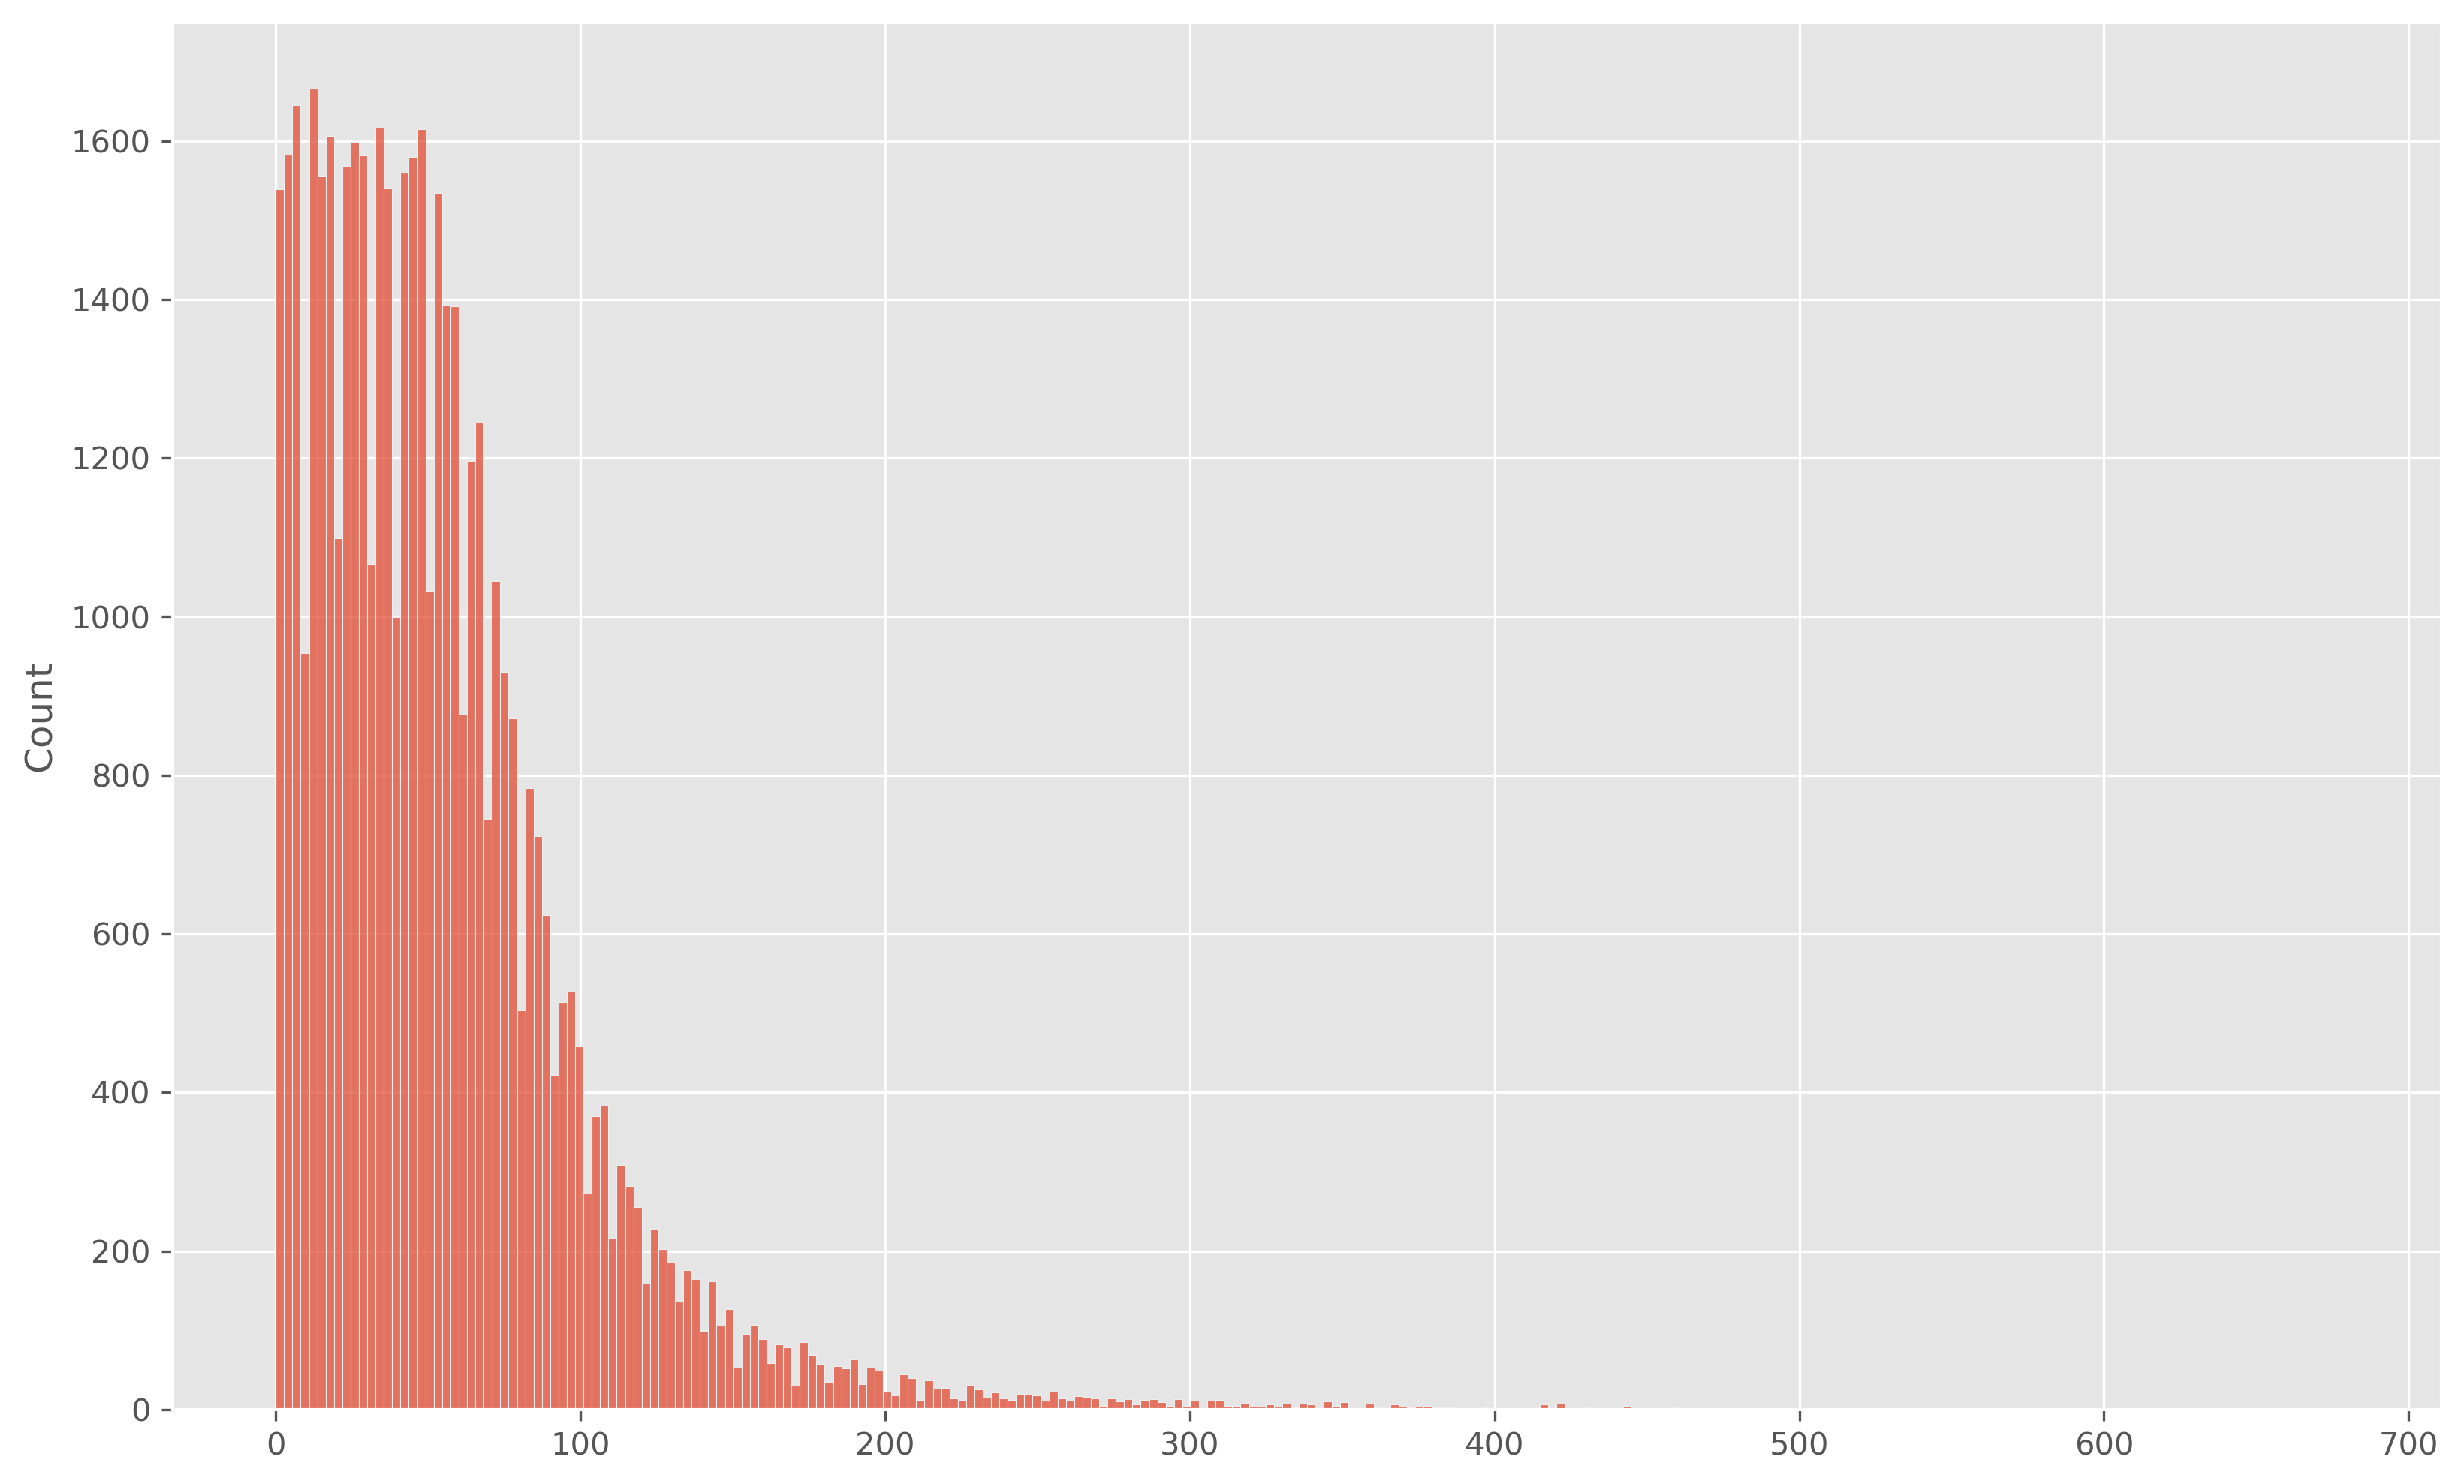

In [106]:
sns.histplot(diffs)